# Machine Learning project

Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.

This project was done following the book  _Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition, by Aurélien Géron (O’Reilly). Copyright 2019 Kiwisoft S.A.S., 978-1-492-03264-9._ and the article _train_test_split Vs StratifiedShuffleSplit by Aboze Brain John Jnr_ https://link.medium.com/NGpPBZ9kR6

## Setup
First, let's import a few common modules and ensure MatplotLib plots figures inline.

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline

## Get the data

In [2]:
housing = pd.read_csv('DATA/housing.csv')

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Each row represents one district. There are 13 attributes: longitude, latitude, housing_median_age, total_rooms, total_bed
rooms, population, households, median_income, median_house_value, and
ocean_proximity.

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


There are 20,640 instances in the dataset. Notice that the total_bed
rooms attribute has only 20,433 nonnull values, meaning that 207 districts are missing
this feature.

In [5]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

All attributes are numerical, except the ocean_proximity field. Its type is object, but since this data comes from a CSV file,
it must be a text attribute. Looking at the top five rows, it can be
notice that the values in the ocean_proximity column are repetitive,
which means that it is probably a categorical attribute. Above it can be seen what categories exist and how many districts belong to each category


Let’s look at the other fields. The describe() method shows a summary of the
numerical attributes

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


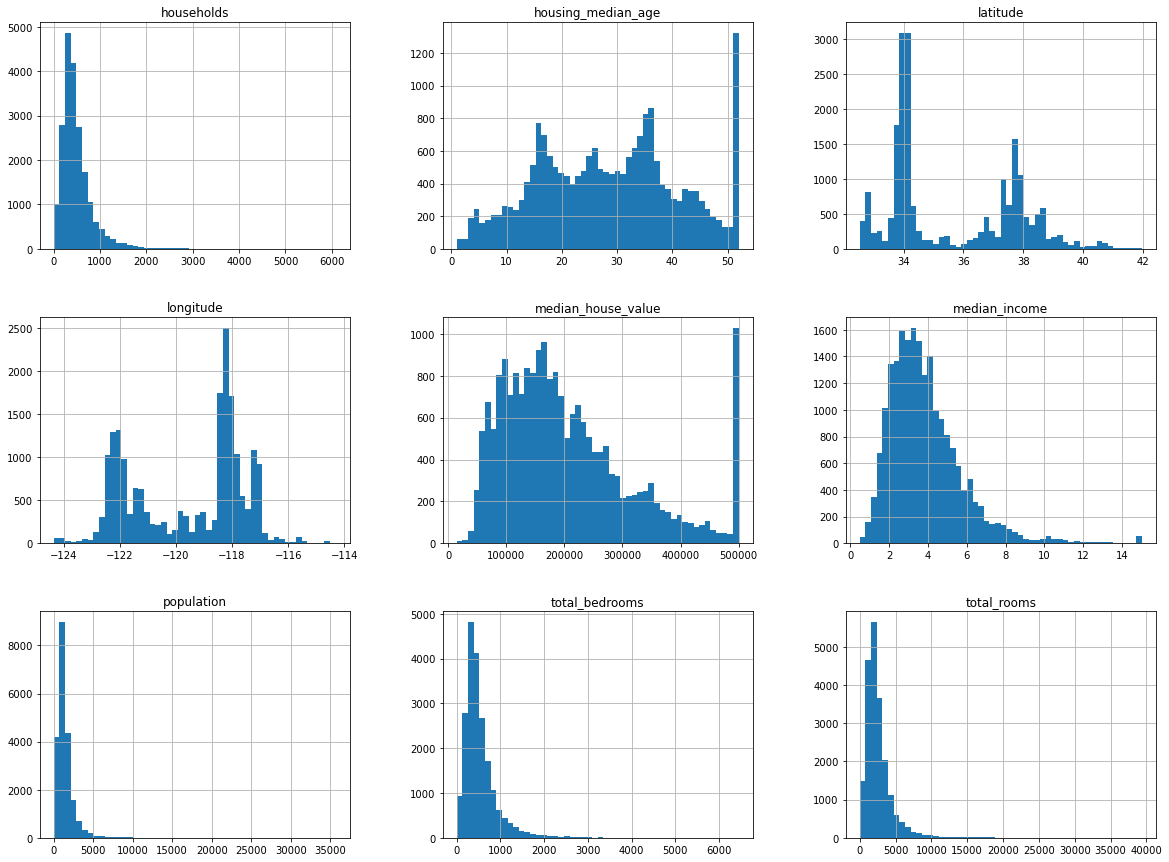

In [7]:
housing.hist(bins=50,figsize=(20,15))
plt.show()

1. First, the median income attribute does not look like it is expressed in US dollars(USD). After checking with the team that collected the data, they explained it is because the data has been scaled and capped at 15 for higher median incomes, and at 0.5 for lower median incomes. The numbers represent roughly tens of thousands of dollars (e.g., 3 actually means about $30,000).


2. The housing median age and the median house value were also capped.


3. These attributes have very different scales.


4. Finally, many histograms are tail-heavy: they extend much farther to the right of
the median than to the left.

Using a correlation to see features that are highly correlated to the target(here, median_housing_value)

In [8]:
corr_matrix = housing.corr()

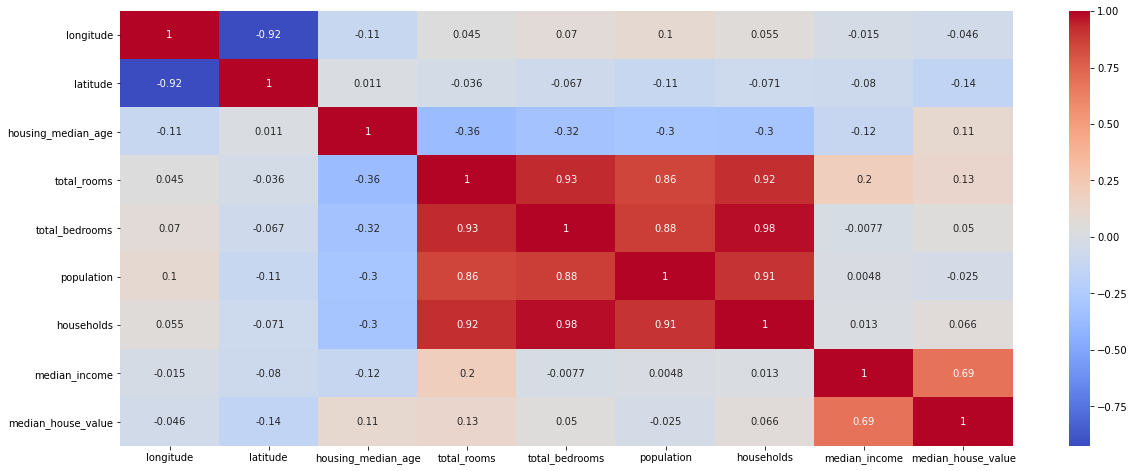

In [9]:
plt.figure(figsize=(20,8))
sns.heatmap(corr_matrix,cmap='coolwarm',annot=True)

It can be observed from the heatmap that median_income is highly correlated to the target, having '0.69', so lets look at the feature more closely.

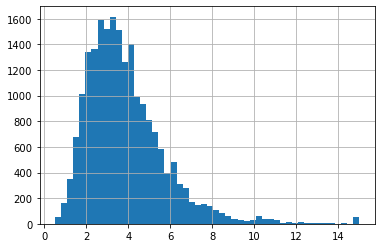

In [10]:
housing["median_income"].hist(bins=50)

## Using StratifiedShuffleSplit approach to split the data

Since we have seen from the correlation heatmap that the 'median_income' feature is important. We will want our test set to be representative of the various categories of income in the whole dataset. If we look at the histogram of the 'median_income' we created before, you will observe that most of median income values are clustered around 1.5 to 6 (i.e $15,000-$60,000), but some 'median_income' values go far beyond 6.

So we create 5 strata in this project.We will create 5 category attribute labeled 1 to 5(where label 1 depicts values from 0-1.5,label 2 depicts values from 1.5-3 an so on till label 5 depicts 6-inf which covers the remaining values on the histogram)

In [11]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0.,1.5,3.0,4.5,6.,np.inf],
                               labels =[1,2,3,4,5])

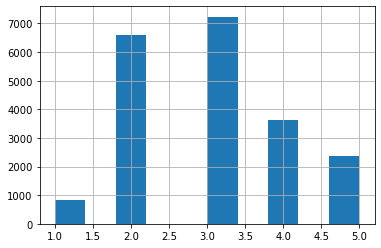

In [12]:
housing["income_cat"].hist()

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

In [14]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Let's check if it worked as expected as we observe the proportion

In [15]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

With this similar code it can be measure the income category proportions in the full data‐
set. The next table compares the income category proportions in the overall dataset, in
the test set generated with stratified sampling, and in a test set generated using purely
random sampling. As it can be seen, the test set generated using stratified sampling has
income category proportions almost identical to those in the full dataset, whereas the
test set generated using purely random sampling is skewed.

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

In [18]:
train_set1, test_set1 = train_test_split(housing, test_size=0.2, random_state=42)

In [19]:
compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Random": income_cat_proportions(test_set1),
    "Stratified": income_cat_proportions(strat_test_set),  
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [20]:
compare_props

,Overall,Random,Stratified,Rand. %error,Strat. %error
1,0.039826,0.040213,0.039729,0.973236,-0.243309
2,0.318847,0.324370,0.318798,1.732260,-0.015195
3,0.350581,0.358527,0.350533,2.266446,-0.013820
4,0.176308,0.167393,0.176357,-5.056334,0.027480
5,0.114438,0.109496,0.114583,-4.318374,0.127011


So we should drop the income category, so the data is back to its original form

In [21]:
for set_ in (strat_train_set,strat_test_set):
    set_.drop("income_cat",axis=1,inplace=True)

## Discover and Visualize the Data to Gain Insights

In [22]:
housing = strat_train_set.copy()

### Visualizing Geographical Data
There is geographical information (latitude and longitude), it is a good idea to
create a scatterplot of all districts to visualize the data. Setting the alpha option to 0.1 makes it much easier to visualize the places where there is a high density of data points

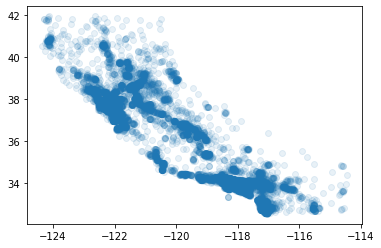

In [23]:
plt.scatter(housing["longitude"],housing["latitude"],alpha=0.1)

It can clearly be seen the high-density areas, namely the Bay Area and around Los Angeles and San Diego, plus a long line of fairly high density in the Central Valley, in particular around Sacramento and Fresno

Now let’s look at the housing prices. The radius of each circle represents the district’s population (option s), and the color represents the price (option c). We will use a predefined color map (option cmap) called jet, which ranges from blue
(low values) to red (high prices)

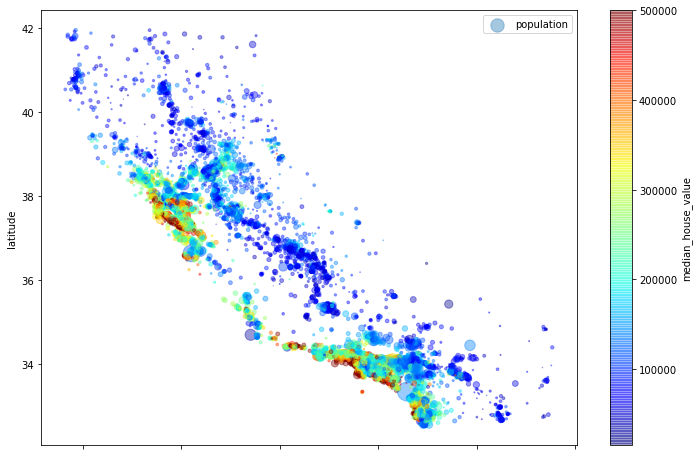

In [24]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
 s=housing["population"]/100, label="population", figsize=(12,8),
 c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()


This image tells you that the housing prices are very much related to the location
(e.g., close to the ocean) and to the population density. The ocean proximity attribute may be useful as well, although in Northern California the housing prices in coastal districts are not too high.

Now let’s look at how much each attribute correlates with the median house value:

In [25]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

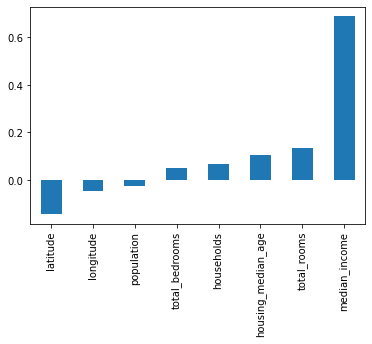

In [26]:
corr_matrix['median_house_value'][:-1].sort_values().plot(kind="bar")

It can be seen that the median house value tends to go up when the median income goes up. Also, a small negative correlation between the latitude and the median house value (i.e., prices have a slight tendency to go down when you go north)

Another way to check for correlation between attributes is with a graphic to plot every numerical attribute against every other numerical attribute

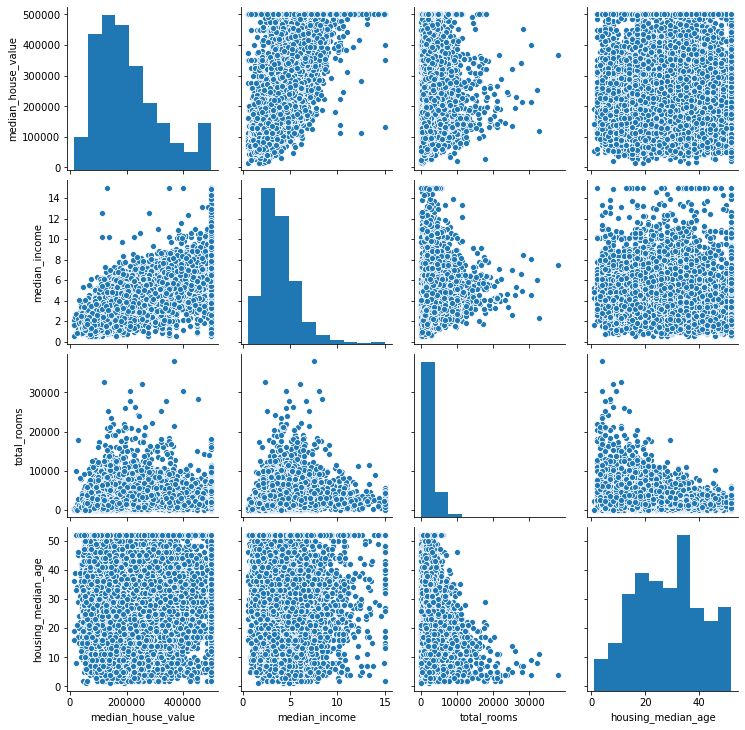

In [27]:
attributes =['median_house_value','median_income','total_rooms','housing_median_age']
sns.pairplot(housing[attributes],)

The most promising attribute to predict the median house value is the median income, so let’s zoom in on their correlation scatterplot

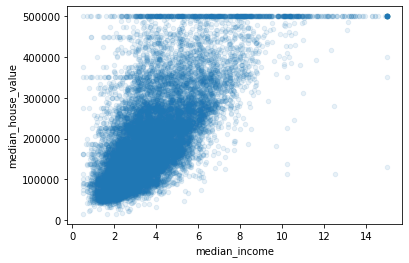

In [28]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",alpha=0.1)

This plot reveals a few things. First, the correlation is indeed very strong; you can clearly see the upward trend, and the points are not too dispersed. Second, the price cap that we noticed earlier is clearly visible as a horizontal line at 500,000. But this plot reveals other less obvious straight lines: a horizontal line around 450,000,
another around 350,000, perhaps one around 280,000, and a few more below that.

## Experimenting with Attribute Combinations

The total number of rooms in a district is not very useful if you don’t know how many households there are. What you really want is the number of rooms per household. Similarly, the total number of bedrooms by itself is not very useful: you probably want to compare it to the number of rooms. And the population per household also seems like an
interesting attribute combination to look at. Let’s create these new attributes:

In [29]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

And now let’s look at the correlation matrix again:

In [30]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688883
rooms_per_household         0.157620
total_rooms                 0.137469
housing_median_age          0.107144
households                  0.069177
total_bedrooms              0.053544
population                 -0.023797
population_per_household   -0.026888
longitude                  -0.043236
latitude                   -0.145570
bedrooms_per_room          -0.255870
Name: median_house_value, dtype: float64

The new bedrooms_per_room attribute is much more correlated with the median house value than the total number of rooms or bedrooms. Apparently houses with a lower bedroom/room ratio tend to be more expensive. The number of rooms per household is also more informative than the total number of rooms in a district—obviously the larger the houses, the more expensive they are.

## Prepare the Data for Machine Learning Algorithms

In [31]:
housing = strat_train_set.drop("median_house_value",axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Data Cleaning

We saw earlier that the total_bedrooms attribute has some missing values, so let’s fix this setting the values to the median

In [32]:
from sklearn.impute import SimpleImputer

In [33]:
imputer = SimpleImputer(strategy="median")

In [34]:
housing_num = housing.drop("ocean_proximity",axis=1)

In [35]:
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [36]:
imputer.statistics_

array([-118.49  ,   34.25  ,   29.    , 2128.5   ,  436.    , 1167.    ,
        410.    ,    3.5341])

In [37]:
housing_num.median().values

array([-118.49  ,   34.25  ,   29.    , 2128.5   ,  436.    , 1167.    ,
        410.    ,    3.5341])

In [38]:
X = imputer.transform(housing_num)

In [39]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,index=housing_num.index)


In [40]:
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 10275 to 4303
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


### Handling Text and Categorical Attributes

So far we have only dealt with numerical attributes, but now let’s look at text
attributes. In this dataset, there is just one: the ocean_proximity attribute. Let’s look
at its value for the first 10 instances:

In [41]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
10275,<1H OCEAN
20601,INLAND
20138,<1H OCEAN
18028,<1H OCEAN
16289,INLAND
4622,<1H OCEAN
15280,NEAR OCEAN
17228,<1H OCEAN
14268,NEAR OCEAN
1229,INLAND


It’s not arbitrary text: there are a limited number of possible values, each of which
represents a category. So this attribute is a categorical attribute. Most Machine Learning algorithms prefer to work with numbers, so let’s convert these categories from
text to numbers. For this, we can use Scikit-Learn’s OrdinalEncoder class

In [42]:
from sklearn.preprocessing import OneHotEncoder

In [43]:
cat_encoder = OneHotEncoder(sparse=False)

In [44]:
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [45]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Custom Transformers

Here is a small transformer class that adds the combined attributes we
discussed earlier

In [46]:
from sklearn.base import BaseEstimator, TransformerMixin

In [47]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

In [48]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): #no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self #nothing else to do
    def transform(self, X):
        rooms_per_household = X[:,rooms_ix] / X[:,households_ix]
        population_per_household = X[:,population_ix] / X[:,households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_ix] / X[:,rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                        bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        

In [49]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)

In [50]:
housing_extra_attribs = attr_adder.transform(housing.values)

In this example the transformer has one hyperparameter, add_bedrooms_per_room,
set to True by default (it is often helpful to provide sensible defaults). This hyperpara‐
meter will allow you to easily find out whether adding this attribute helps the
Machine Learning algorithms or not

### Feature Scaling

Machine Learning algorithms don’t perform well when
the input numerical attributes have very different scales. This is the case for the housing data: the total number of rooms ranges from about 6 to 39,320, while the median
incomes only range from 0 to 15.

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [52]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
 ])
housing_prepared = full_pipeline.fit_transform(housing)

## Select and Train a Model

### Training and Evaluating on the Training Set
Let’s first train a Linear Regression model. Let’s measure the RMSE on the cross validation sets using Scikit-Learn’s mean_squared_error() function:

In [53]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [54]:
# evaluate each model in turn
models = []
models.append(('LR', LinearRegression()))
models.append(('DTR', DecisionTreeRegressor()))
models.append(('RFC', RandomForestRegressor()))

results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, housing_prepared, housing_labels, cv=10, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-cv_results)
    results.append(rmse_scores)
    names.append(name)
    print('%s: %f (%f)' % (name, rmse_scores.mean(), rmse_scores.std()))

LR: 68480.729288 (1456.394289)
DTR: 70452.893984 (2075.570151)
RFC: 50359.600691 (1566.489694)


Text(0.5, 1.0, 'Algorithm Comparison ')

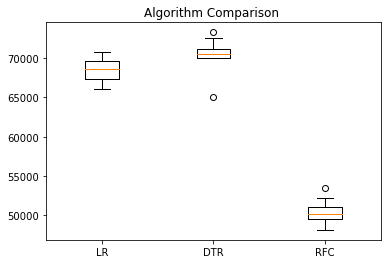

In [55]:
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison ')

The best score is obteined using RF where: most districts’ median_hous
ing_values range between 120,000 and 265,000, so a typical prediction error will be of
$50,325 which is better than the other models but can be not very satisfying and can be improved using GridSearch

## Fine-Tuning the Model

In [56]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

The, the following code searches for the best combination of hyperparameter values for the RandomForestRegressor:

In [57]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [58]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)


64270.43662389979 {'max_features': 2, 'n_estimators': 3}
55648.93987191406 {'max_features': 2, 'n_estimators': 10}
53182.861129826546 {'max_features': 2, 'n_estimators': 30}
59424.32276086727 {'max_features': 4, 'n_estimators': 3}
52796.32740190625 {'max_features': 4, 'n_estimators': 10}
50542.85099818166 {'max_features': 4, 'n_estimators': 30}
58287.44349267417 {'max_features': 6, 'n_estimators': 3}
52271.077291932685 {'max_features': 6, 'n_estimators': 10}
50356.93054757595 {'max_features': 6, 'n_estimators': 30}
58165.452826425004 {'max_features': 8, 'n_estimators': 3}
52305.46851194725 {'max_features': 8, 'n_estimators': 10}
50054.31378914332 {'max_features': 8, 'n_estimators': 30}
62275.432254250445 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54449.866577772744 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.12083339164 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53097.70055480836 {'bootstrap': False, 'max_features': 3, 'n_estimators

We obtain the best solution by setting the max_features hyperpara‐
meter to 8 and the n_estimators hyperparameter to 30. The RMSE score for this
combination is 50,054, which is slightly better than the score you got earlier using the
default hyperparameter values (which was 50,327)

## Ensemble Methods
### Analyze the Best Models and Their Errors
The RandomForestRegressor can indicate the relative importance of each
attribute for making accurate predictions:

In [59]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.04557241e-02, 6.15128115e-02, 4.25672878e-02, 1.57000472e-02,
       1.49284851e-02, 1.49084337e-02, 1.44207566e-02, 3.76291817e-01,
       4.81760955e-02, 1.05983382e-01, 5.98885423e-02, 5.59223098e-03,
       1.63884097e-01, 3.10570422e-04, 1.94175701e-03, 3.43796228e-03])

Let’s display these importance scores next to their corresponding attribute names:

In [60]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)


[(0.376291816807621, 'median_income'),
 (0.163884097059388, 'INLAND'),
 (0.10598338151098492, 'pop_per_hhold'),
 (0.07045572412975173, 'longitude'),
 (0.06151281154221238, 'latitude'),
 (0.059888542336596844, 'bedrooms_per_room'),
 (0.04817609548550473, 'rooms_per_hhold'),
 (0.04256728779569895, 'housing_median_age'),
 (0.01570004721382453, 'total_rooms'),
 (0.014928485093804934, 'total_bedrooms'),
 (0.014908433720649266, 'population'),
 (0.014420756602583398, 'households'),
 (0.005592230984976704, '<1H OCEAN'),
 (0.003437962282887853, 'NEAR OCEAN'),
 (0.0019417570111563516, 'NEAR BAY'),
 (0.00031057042235842176, 'ISLAND')]

## Evaluate Your System on the Test Set

In [61]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [62]:
final_rmse

48840.40683881032

In [63]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([46668.91173059, 50919.38096878])

In some cases, such a point estimate of the generalization error will not be quite
enough to convince to launch. For this, you we computep a 95% confidence interval for the generalization error using
scipy.stats.t.interval():

Which tell us that 95% times the value rmse value will be around 46.668 and 50.919